In [1]:
#Downloading Cancer Data from Kaggle

# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("multi-cancer")

# print("Path to dataset files:", path)

In [8]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [29]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
torch.manual_seed(1)

In [10]:
# Loading the Data

# Preparing the Training Data

In [21]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(3)], [0.5 for _ in range(3)])  # for 3 channels (RGB)
])

In [24]:
dataset_path = "Multi Cancer//Multi Cancer//ALL"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7176471..1.0].
Clipping input data to the

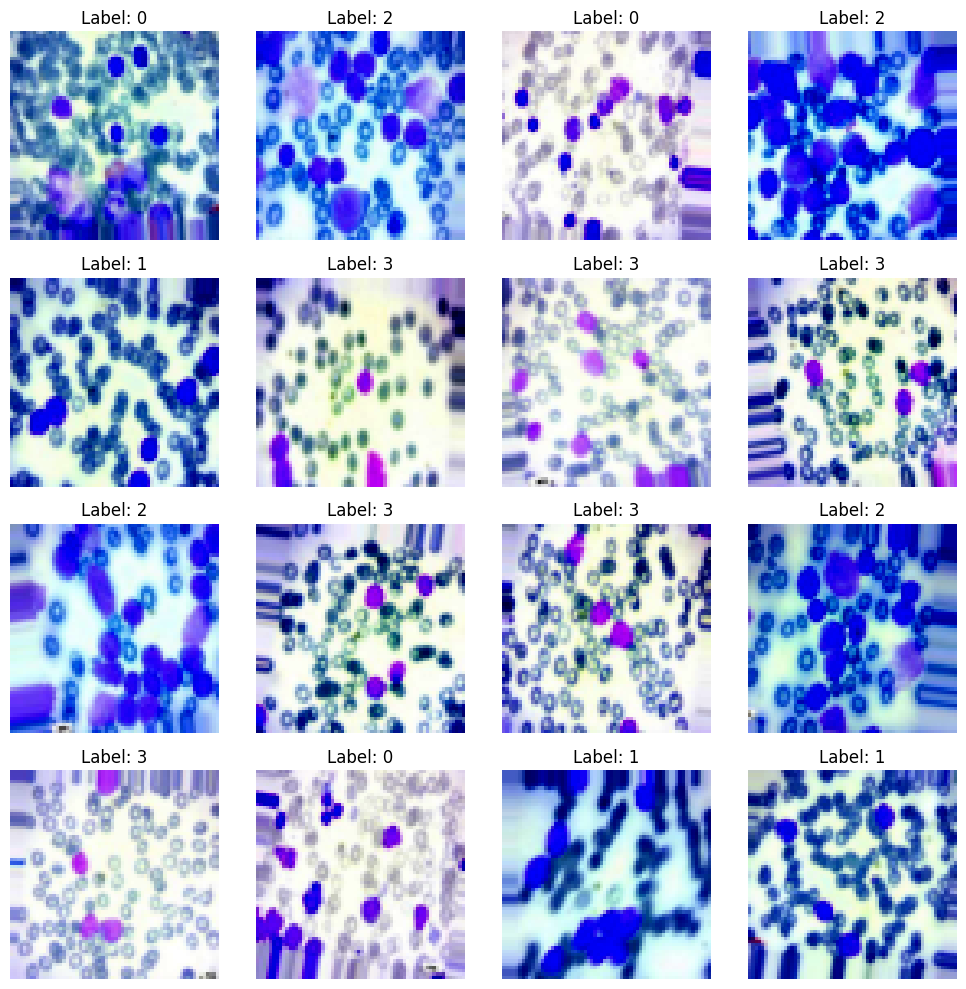

In [31]:
import matplotlib.pyplot as plt

# Fetch one batch from the DataLoader
real_samples, labels = next(iter(dataloader))  # shape: [B, 3, H, W]

# Plot 16 RGB images
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = real_samples[i].permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Implementing the Discriminator and the Generator

In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch_size, 3, 64, 64)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 12288)
        return self.model(x)

In [35]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [36]:
discriminator = Discriminator().to(device=device)

In [37]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024,3 * 64 * 64),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 3, 64, 64)
        return output

generator = Generator().to(device=device)

In [48]:
lr = 0.0001
batch_size = 32
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [49]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        current_batch_size = real_samples.size(0)

        # === Labels ===
        real_labels = torch.ones((current_batch_size, 1), device=device)
        fake_labels = torch.zeros((current_batch_size, 1), device=device)

        # === Generate Fake Images ===
        noise = torch.randn((current_batch_size, 100), device=device)
        fake_samples = generator(noise)

        # === Train Discriminator ===
        discriminator.zero_grad()
        all_samples = torch.cat((real_samples, fake_samples.detach()))
        all_labels = torch.cat((real_labels, fake_labels))
        d_output = discriminator(all_samples)
        d_loss = loss_function(d_output, all_labels)
        d_loss.backward()
        optimizer_discriminator.step()

        # === Train Generator ===
        generator.zero_grad()
        noise = torch.randn((current_batch_size, 100), device=device)
        fake_samples = generator(noise)
        g_output = discriminator(fake_samples)
        g_loss = loss_function(g_output, real_labels)  # Trick D
        g_loss.backward()
        optimizer_generator.step()

        # === Logging ===
        if n % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{n}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [1/50] Batch [0] | D Loss: 0.6523 | G Loss: 0.7500
Epoch [1/50] Batch [100] | D Loss: 0.6269 | G Loss: 1.0035
Epoch [1/50] Batch [200] | D Loss: 0.6655 | G Loss: 0.6933
Epoch [1/50] Batch [300] | D Loss: 0.7186 | G Loss: 0.8532
Epoch [2/50] Batch [0] | D Loss: 0.5542 | G Loss: 1.1469
Epoch [2/50] Batch [100] | D Loss: 0.6545 | G Loss: 0.8328
Epoch [2/50] Batch [200] | D Loss: 0.5195 | G Loss: 1.1964
Epoch [2/50] Batch [300] | D Loss: 0.6252 | G Loss: 1.1337
Epoch [3/50] Batch [0] | D Loss: 0.6571 | G Loss: 1.0021
Epoch [3/50] Batch [100] | D Loss: 0.6807 | G Loss: 0.6970
Epoch [3/50] Batch [200] | D Loss: 0.7780 | G Loss: 0.7772
Epoch [3/50] Batch [300] | D Loss: 0.6822 | G Loss: 1.2743
Epoch [4/50] Batch [0] | D Loss: 0.7395 | G Loss: 0.7347
Epoch [4/50] Batch [100] | D Loss: 0.6426 | G Loss: 0.8672
Epoch [4/50] Batch [200] | D Loss: 0.6249 | G Loss: 0.9026
Epoch [4/50] Batch [300] | D Loss: 0.6945 | G Loss: 0.7945
Epoch [5/50] Batch [0] | D Loss: 0.6703 | G Loss: 0.9039
Epoch [

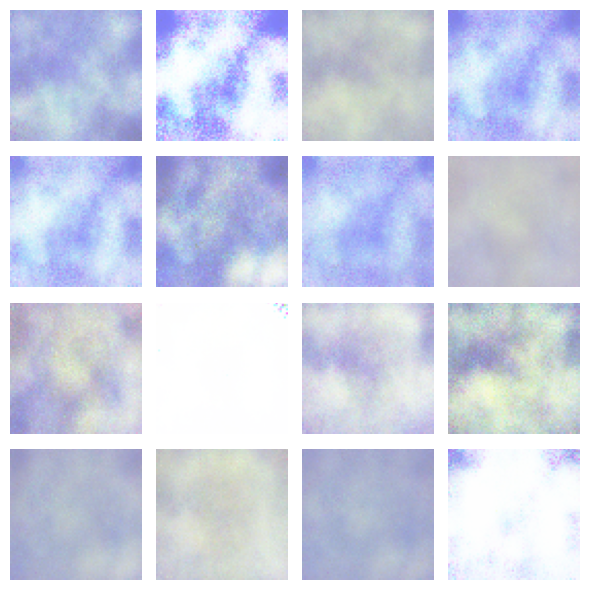

In [50]:
# Generate 16 RGB images from the generator
latent_space_samples = torch.randn(16, 100).to(device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

# Plotting the RGB images
plt.figure(figsize=(6, 6))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = generated_samples[i]

    # Convert from (C, H, W) -> (H, W, C)
    img = img.permute(1, 2, 0)

    # Normalize to [0,1] for imshow (if Tanh used, outputs in [-1,1])
    img = (img + 1) / 2  # From [-1, 1] → [0, 1]

    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()